# Bitcoin Price Prediction

Bitcoin (₿) is a decentralized digital currency, without a central bank or single administrator, that can be sent from user to user on the peer-to-peer bitcoin network without the need for intermediaries. Transactions are verified by network nodes through cryptography and recorded in a public distributed ledger called a blockchain. The cryptocurrency was invented in 2008 by an unknown person or group of people using the name Satoshi Nakamoto. The currency began use in 2009 when its implementation was released as open-source software.
    
Bitcoin has also fueled a rise of plethora of other cryptocurrencies, but Bitcoin still remains the king of them all. Bitcoin has the highest Market Capitalization of any cryptocurrency. Since Bitcoin and other cryptocurrencies are actively traded 24/7 and as Bitcoin remains as the most dominant of all the cryptocurrencies, the price of other crytos are mostly dictated with according to the price action of Bitcoin. So Bitcoin's Price prediction can be a game changer for crypto enthusiastic traders accross the globe.

The Historic market data, which is a time series data of 1 day(1D) time frame is used for this project. From the historic price action  we can see that Bitcoin is highly volatile compared to conventional stocks. So the time series model won't be very accurate and dependable, Nonetheless this is just an attempt to see how close we can get.
    

In [35]:
#Import all necessary libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler,StandardScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM,Dense,Softmax,Dropout
import requests
import config
import csv
import json
import datetime
%matplotlib inline

### Bitcoin Fear and Greed index

This is a widely used market indicator related to market sentiment towards the price action. Historically bitcoin price has bounced back from "Extreme Fear" territories and revrsed from "Extreme Greed" phase as well. Hence this can prove to be a valuable variable for the price prediction.

In [2]:
#Fear and Greed index in 1D timeframe
CSV_URL = 'https://api.alternative.me/fng/?limit=0&format=csv'


with requests.Session() as s:
    download = s.get(CSV_URL)

    decoded_content = download.content.decode('utf-8')

    cr = csv.reader(decoded_content.splitlines(), delimiter=',')
    my_list = list(cr)
    my_list = my_list[4:-5]

        
df = pd.DataFrame(my_list,columns = ['date','fng_value','fng_class'])
df['date'] = pd.to_datetime(df['date'],format = '%d-%m-%Y')

### Bitcoin Price data in 1d timeframe

Bitcoin is traded across various crypto exchanges. Eventhough prices don't vary so much, the traded volume each day may have some major differences. Binance is one of the most popular Crypto Exchanges globally. Hence the volume data from this exchange can be considered to be a better representation of the overall volume. 

In [3]:
#BTC price data in 1D timeframe
btc = 'https://api.cryptowat.ch/markets/binance/btcusdt/ohlc?periods=86400'
with requests.Session() as s:
    download = s.get(btc)

    decoded_content = download.content.decode('utf-8')
    
jn = json.loads(decoded_content)
price = pd.DataFrame(jn['result']['86400'], columns = ['date','Open','High', 'Low', 'Close', 'Volume_btc','Volume_usd'])
price['date'] = pd.to_datetime(price['date'],unit = 's')    

### Bitcoin Onchain metrics

There are various On-chain metrics that are used by crypto traders, such as the movements of bitcoin whales, open interest in the futures trading market, mining difficulty and realized market cap. Onchain metrics make use of data from blockchain ledger to indicate market sentiment.

As a strating step I have used only 1 indicator called SOPR. SOPR is an indicator that measures the profit or loss of every single transaction that is made in the market. This is done by measuring the difference between the purchase and sale prices. Therefore, it shows whether the overall market is at a profit or at a loss.

A SOPR >1 means that participants in the market are selling at a profit, while the opposite is true for values <1.

In [36]:
#SOPR value in 1D timeframe
onc = requests.get('https://api.cryptoquant.com/v1/Bitcoin/Exchange-Flows')
API_KEY = config.api_key

res = requests.get('https://api.glassnode.com/v1/metrics/indicators/sopr',
    params={'a': 'BTC', 'api_key': API_KEY})

rs = res.content.decode('utf-8')

# convert to pandas dataframe
sopr = pd.read_json(res.text, convert_dates=['t'])
sopr.rename(columns={'t':'date', 'v':'sopr_val'}, inplace = True)


In [5]:
# Join the three tables on date into a single dataframe

pfng = df.merge(price, on = 'date', how='inner')
pfngs = pfng.merge(sopr, on = 'date', how='inner')
pfngs = pfngs[::-1].reset_index(drop = True)
pfngs.to_csv(r'btc_pfngs.csv', index=False)
pfngs.set_index('date', inplace=True)
pfngs

,fng_value,fng_class,Open,High,Low,Close,Volume_btc,Volume_usd,sopr_val
date,,,,,,,,,
2018-02-01,30,Fear,10056.99,10298.00,10005.00,10285.10,1596.23080,1.619632e+07,0.984172
2018-02-02,15,Extreme Fear,10285.10,10335.00,8750.99,9224.51,33514.46500,3.171940e+08,0.940699
2018-02-03,40,Fear,9224.51,9250.00,8010.02,8873.03,49416.13300,4.293096e+08,0.982948
2018-02-04,24,Extreme Fear,8873.02,9473.01,8229.00,9199.96,27992.14000,2.506866e+08,1.008924
2018-02-05,11,Extreme Fear,9194.06,9368.00,7930.00,8184.81,31986.71300,2.746673e+08,0.961208
...,...,...,...,...,...,...,...,...,...
2022-06-02,13,Extreme Fear,31801.05,31982.97,29301.00,29805.83,103395.63382,3.171191e+09,0.984505
2022-06-03,10,Extreme Fear,29805.84,30689.00,29594.55,30452.62,56961.42928,1.711653e+09,0.993358
2022-06-04,14,Extreme Fear,30452.63,30699.00,29282.36,29700.21,54067.44727,1.615617e+09,0.989313


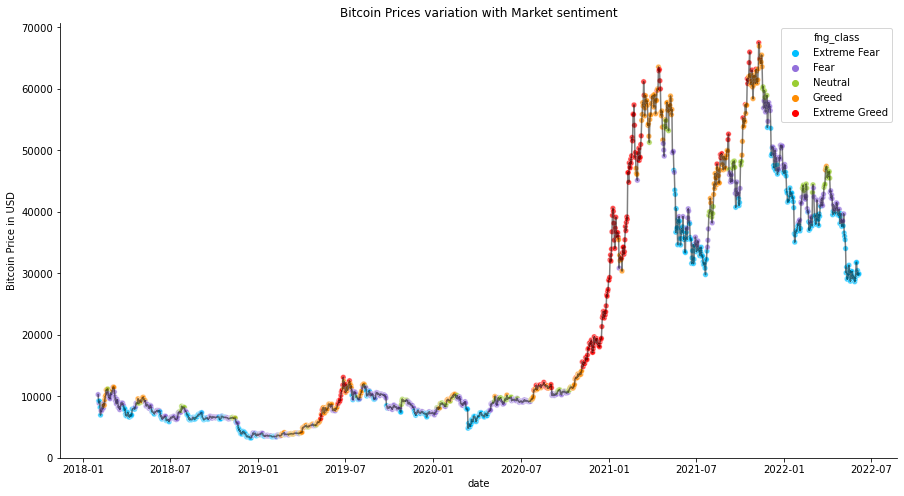

In [6]:
plt.figure(figsize=(15,8))
ax=sns.lineplot(x=pfngs.index,y=pfngs['Close'], color='black', alpha=0.5)
sns.scatterplot(x=pfngs.index,y=pfngs['Close'], s=30, alpha=0.7,hue=pfngs['fng_class'],
                hue_order=['Extreme Fear','Fear','Neutral','Greed','Extreme Greed'],
                palette=['deepskyblue','mediumpurple','yellowgreen','darkorange','red'],ax=ax)
plt.title('Bitcoin Prices variation with Market sentiment')
plt.ylabel('Bitcoin Price in USD')
sns.despine()
plt.show()

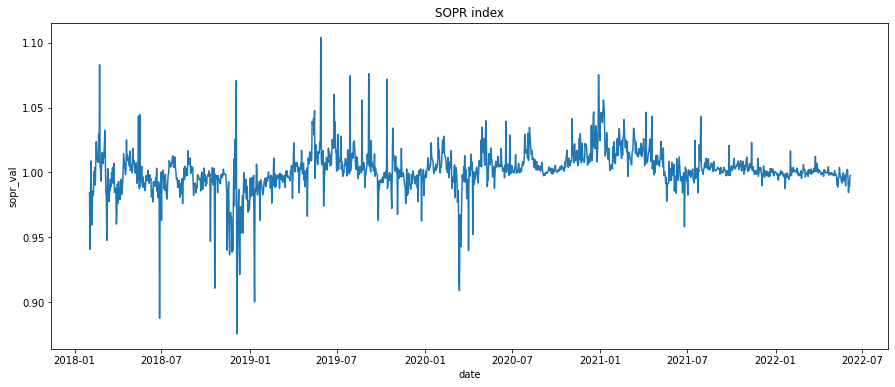

In [7]:
plt.figure(figsize=(15,6))
sns.lineplot(data=pfngs,x=pfngs.index,y='sopr_val')
plt.title('SOPR index')
plt.show()

In [8]:
# Drop fear-Greed categorical variable as fear and greed value is retained
pfngs.drop(columns='fng_class', inplace=True)

## Univariate Time series Price Prediction using LSTM

In Univariate time series prediction I'm only considering Close price as the dependent variable. Since we are dealing with time series data, the objective is to see the closing price of the past 'x' days and predict the price of the next day. For training I'm using 85% of historic price and window size as 75 days.

In [9]:
#Normalize the Close price between 0 to 1

scaler = MinMaxScaler(feature_range=(0,1))
close = np.array(pfngs['Close']).reshape(-1,1)
scaler.fit(close)
close_t = scaler.transform(close)

In [10]:
# train-test split 

train_len = round(len(close)*0.85)
train_split = close_t[0:train_len,:]
test_split = close_t[train_len:len(close),:1]

In [11]:
def create_dataset(data, window_size=1):
    
    '''
    Parameters-
    data        : 2-D numpy array of price data.
    window_size : No. of days to look behind that need to be fed to the model as input.
    
    Returns - 
    Price data each of length specified by window_size and the corresponding price of day after.
    '''
    
    data_X, data_Y = [],[]
    for i in range(len(data)- window_size):
        x = data[i:i+window_size,:]
        y = data[i+window_size,0]
        data_X.append(x)
        data_Y.append(y)
    return np.array(data_X), np.array(data_Y)

In [12]:
# Convert train data to be fed into the model for training

window_size = 75
train_X, train_Y = create_dataset(train_split, window_size)
train_X = np.reshape(train_X,(train_X.shape[0],train_X.shape[1],1))

# Convert test data to be fed into the model for prediction after training

window_size = 75
test_X, test_Y = create_dataset(test_split, window_size)
test_X = np.reshape(test_X,(test_X.shape[0],test_X.shape[1],1))

In [13]:
#Create the 5 Layered Model 

model_uni = Sequential()
model_uni.add(LSTM(256, return_sequences = True,input_shape=(train_X.shape[1],train_X.shape[2])))
model_uni.add(Dropout(0.2))
model_uni.add(LSTM(128, return_sequences = True))
model_uni.add(LSTM(50))
model_uni.add(Dense(1))

model_uni.compile(optimizer = 'adam',loss = 'mean_squared_error')

model_uni.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 75, 256)           264192    
_________________________________________________________________
dropout (Dropout)            (None, 75, 256)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 75, 128)           197120    
_________________________________________________________________
lstm_2 (LSTM)                (None, 50)                35800     
_________________________________________________________________
dense (Dense)                (None, 1)                 51        
Total params: 497,163
Trainable params: 497,163
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Training for 100 epochs

hist = model_uni.fit(train_X, train_Y, validation_data = (test_X, test_Y),epochs=100)

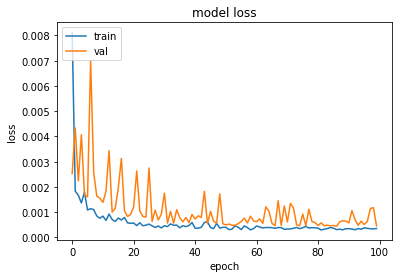

In [15]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [16]:
# Predict on train and test data

train_res = model_uni.predict(train_X)
test_res = model_uni.predict(test_X)

# Convert back the normalized prices to USD

train_price = scaler.inverse_transform(train_res)
test_price = scaler.inverse_transform(test_res)

In [17]:
# Evaluating the model on the test data using RMSE (Root Mean Squared Error)

import math
from sklearn.metrics import mean_squared_error

rmse_test = math.sqrt(mean_squared_error(test_price, scaler.inverse_transform(test_Y.reshape(-1,1))))

rmse_train = math.sqrt(mean_squared_error(train_price, scaler.inverse_transform(train_Y.reshape(-1,1))))

print('The Root Mean Squared Error(RMSE) for Test Dataset is :', rmse_test)
print('The Root Mean Squared Error(RMSE) for Train Dataset is :', rmse_train)

The Root Mean Squared Error(RMSE) for Test Dataset is : 1376.8542746573246
The Root Mean Squared Error(RMSE) for Train Dataset is : 976.7375777161311


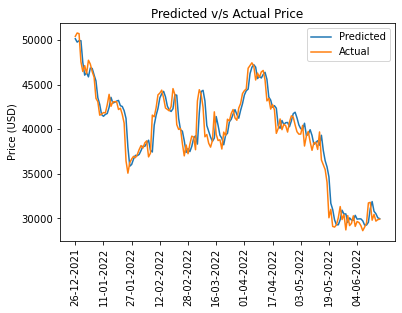

In [18]:
#Plot of predicted price v/s Actual price for test data
plt.title('Predicted v/s Actual Price')
plt.ylabel('Price (USD)')
plt.xticks(labels=list(pfngs.index[-len(test_price)::16].strftime(date_format='%d-%m-%Y')), ticks=np.arange(0,160,15), rotation = 90)
plt.plot(test_price, label='Predicted')
plt.plot(scaler.inverse_transform(test_Y.reshape(-1,1)), label='Actual')
plt.legend()
plt.show()


window size - 15, epoch -50, train-test-split - 0.7, RMSE - 7192.5266029671575\
window size - 50, epoch -50, train-test-split - 0.7, RMSE - 6734.3018968208\
window size - 50, epoch -50, dropout - 0.2(1st layer), train-test-split - 0.7, RMSE - 10380.405993323802\
window size - 50, epoch -50, dropout - 0.2(2nd layer), train-test-split - 0.7, RMSE - 4987.815704978624\
window size - 50, epoch -50, dropout - 0.2(2nd layer), train-test-split - 0.85, RMSE - 2119.3819987660218\
window size - 50, epoch -100, dropout - 0.2(2nd layer), train-test-split - 0.85, RMSE - 1680.3075514704167



In [19]:
def create_test_next(test_X, model, window_size = 75, future_days = 30):
    new_test_X = test_X
    for i in range(future_days):
        Last = new_test_X[-1:]
        last2 = Last[0,1:]
        new = np.append(last2,model.predict(new_test_X[-1:]),axis=0)
        #print(new)
        new_test_X = np.append(new_test_X,new.reshape(1,window_size,1),axis=0)
    return new_test_X
       

In [20]:
new_test_X = create_test_next(test_X, model_uni,window_size = 75,future_days = 30)
new_test_X.shape

(193, 75, 1)

In [21]:
test_res_new = model_uni.predict(new_test_X)

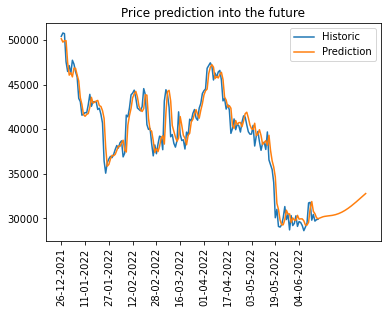

In [22]:
test_price_new = scaler.inverse_transform(test_res_new)
#plt.plot(train_price)
#plt.plot(scaler.inverse_transform(train_Y.reshape(-1,1)))
plt.title('Price prediction into the future')
plt.xticks(labels=list(pfngs.index[-len(test_price)::16].strftime(date_format='%d-%m-%Y')), ticks=np.arange(0,160,15), rotation = 90)
#plt.plot(test_price)
plt.plot(scaler.inverse_transform(test_Y.reshape(-1,1)), label='Historic')
plt.plot(test_price_new, label='Prediction')
plt.legend()
plt.show()

## Multivariate Time series Price Prediction using LSTM

Since we have other useful columns in our dataset that can have an effect on the price of Bitcoin, we can use all these dependent variables to try and predict the price of bitcoin better. 

In [23]:
scaler2 = MinMaxScaler(feature_range=(0,1))
#close = np.array(pfngs['Close']).reshape(-1,1)
scaler2.fit(pfngs)
pfngs_t = scaler2.transform(pfngs)

In [24]:
pfngs_t[0]

array([2.77777778e-01, 1.06435398e-01, 1.06833933e-01, 1.08596150e-01,
       1.09982191e-01, 1.88055932e-04, 1.20171261e-03, 4.75514581e-01])

In [25]:

train_len = round(pfngs.shape[0]*0.85)
train_split2 = pfngs_t[0:train_len,:]
test_split2 = pfngs_t[train_len:,:]

In [26]:
train_split2.shape

(1346, 8)

In [27]:
def create_dataset2(data, window_size=1):
    
    '''
    Parameters-
    data        : 2-D numpy array of all dependent variables.
    window_size : No. of days to look behind that need to be fed to the model as input.
    
    Returns - 
    all dependent variables from the past 'window_size' days and the corresponding closing price of day after.
    '''
    
    data_X, data_Y = [],[]
    for i in range(data.shape[0]- window_size):
        x = data[i:i+window_size,:]
        y = data[i+window_size,4]
        data_X.append(x)
        data_Y.append(y)
    return np.array(data_X), np.array(data_Y)

In [28]:
# Convert train data to be fed into the model for training

window_size = 75
train_X2, train_Y2 = create_dataset2(train_split2, window_size)
#train_X = np.reshape(train_X,(train_X.shape[0],train_X.shape[1],1))

# Convert test data to be fed into the model for prediction after training

window_size = 75
test_X2, test_Y2 = create_dataset2(test_split2, window_size)
#test_X = np.reshape(test_X,(test_X.shape[0],test_X.shape[1],1))

In [29]:
#Create the 5 Layered Model 

model_multi = Sequential()
model_multi.add(LSTM(256, return_sequences = True,input_shape=(train_X2.shape[1],train_X2.shape[2])))
model_multi.add(Dropout(0.2))
model_multi.add(LSTM(128, return_sequences = True))
model_multi.add(LSTM(50))
model_multi.add(Dense(1))

model_multi.compile(optimizer = 'adam',loss = 'mean_squared_error')

model_multi.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 75, 256)           271360    
_________________________________________________________________
dropout_1 (Dropout)          (None, 75, 256)           0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 75, 128)           197120    
_________________________________________________________________
lstm_5 (LSTM)                (None, 50)                35800     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 51        
Total params: 504,331
Trainable params: 504,331
Non-trainable params: 0
_________________________________________________________________


In [ ]:
hist2 = model_multi.fit(train_X2, train_Y2, validation_data = (test_X2, test_Y2),epochs=50)

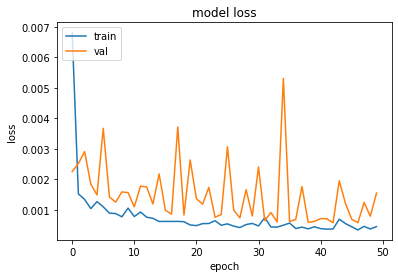

In [31]:
plt.plot(hist2.history['loss'])
plt.plot(hist2.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [32]:
# Predict on train and test data
train_res2 = model_multi.predict(train_X2)
test_res2 = model_multi.predict(test_X2)

scaler_close =  MinMaxScaler(feature_range=(0,1))
scaler_close.fit(np.array(pfngs['Close']).reshape(-1,1))

# Convert back the normalized prices to USD
train_price2 = scaler_close.inverse_transform(train_res2)
test_price2 = scaler_close.inverse_transform(test_res2)

In [33]:
# Evaluating the model on the test data using RMSE (Root Mean Squared Error)

rmse_test2 = math.sqrt(mean_squared_error(test_price2, scaler_close.inverse_transform(test_Y2.reshape(-1,1))))

rmse_train2 = math.sqrt(mean_squared_error(train_price2, scaler_close.inverse_transform(train_Y2.reshape(-1,1))))

print('The Root Mean Squared Error(RMSE) for Test Dataset is :', rmse_test2)
print('The Root Mean Squared Error(RMSE) for Train Dataset is :', rmse_train2)

The Root Mean Squared Error(RMSE) for Test Dataset is : 2527.827279725833
The Root Mean Squared Error(RMSE) for Train Dataset is : 1169.8775585012786


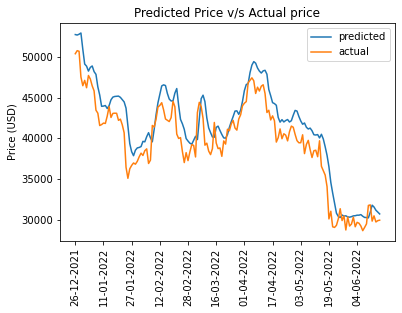

In [34]:
#Plot of predicted price v/s Actual price for test data
plt.title('Predicted Price v/s Actual price')
plt.ylabel('Price (USD)')
plt.xticks(labels=list(pfngs.index[-len(test_price2)::16].strftime(date_format='%d-%m-%Y')), ticks=np.arange(0,160,15), rotation = 90)
plt.plot(test_price2, label='predicted')
plt.plot(scaler_close.inverse_transform(test_Y2.reshape(-1,1)), label='actual')
plt.legend()
plt.show()


In [36]:
model_uni.save("Univariate_model")
model_uni.save_weights("uni_weights.h5")

from tensorflow import keras
model_uni = keras.models.load_model('Univariate_model')
model_uni.load_weights("uni_weights.h5")

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: Univariate_model\assets


In [37]:
model_multi.save("Multivariate_model")
model_multi.save_weights("multi_weights.h5")

from tensorflow import keras
model_multi = keras.models.load_model('Multivariate_model')
model_multi.load_weights("multi_weights.h5")

INFO:tensorflow:Assets written to: Multivariate_model\assets
